In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
import pandas as pd

train = pd.read_csv('drive/MyDrive/data/train.csv')
train.head()

,ID,Utterance,Speaker,Dialogue_ID,Target
0,TRAIN_0000,also I was the point person on my company’s tr...,Chandler,0,neutral
1,TRAIN_0001,You must’ve had your hands full.,The Interviewer,0,neutral
2,TRAIN_0002,That I did. That I did.,Chandler,0,neutral
3,TRAIN_0003,So let’s talk a little bit about your duties.,The Interviewer,0,neutral
4,TRAIN_0004,My duties? All right.,Chandler,0,surprise


In [27]:
label_list = list(set(train['Target']))
label_list

['sadness', 'joy', 'disgust', 'neutral', 'anger', 'surprise', 'fear']

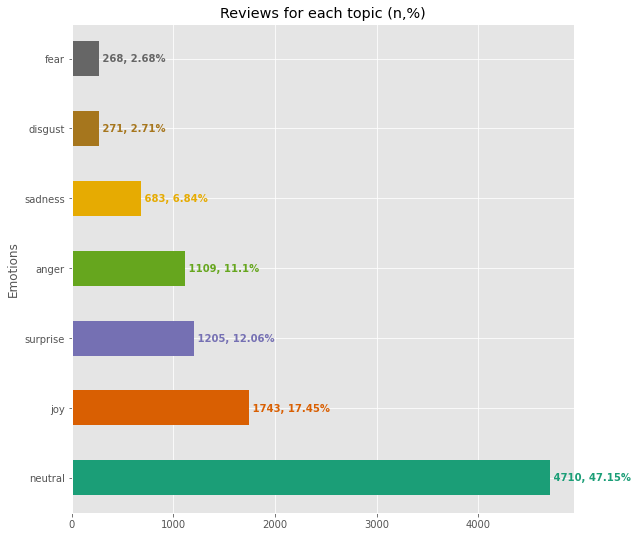

In [5]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

num_classes = len(train['Target'].value_counts())

colors = plt.cm.Dark2(np.linspace(0,1,num_classes))
iter_color = iter(colors)

train['Target'].value_counts().plot.barh(title = "Reviews for each topic (n,%)",
                                      ylabel = "Emotions",
                                      color = colors,
                                      figsize = (9,9))

for i, v in enumerate(train['Target'].value_counts()):
    c = next(iter_color)
    plt.text(v,i,
             " "+str(v)+", "+str(round(v*100/train.shape[0],2))+"%",
             color = c,
             va = 'center',
             fontweight = 'bold')

In [28]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
   list(train["Utterance"]),list(train['Target']), test_size = 0.2, random_state=42
)

In [8]:
!pip install ktrain -q

     |████████████████████████████████| 25.3 MB 271 kB/s 
     |████████████████████████████████| 981 kB 71.6 MB/s 
     |████████████████████████████████| 263 kB 82.5 MB/s 
     |████████████████████████████████| 3.8 MB 82.1 MB/s 
     |████████████████████████████████| 1.3 MB 78.2 MB/s 
     |████████████████████████████████| 468 kB 77.2 MB/s 
     |████████████████████████████████| 7.6 MB 72.0 MB/s 
     |████████████████████████████████| 163 kB 87.6 MB/s 
     |████████████████████████████████| 880 kB 78.0 MB/s 


In [44]:
import ktrain
from ktrain import text

model_name = 'distilbert-base-multilingual-cased'
t = text.Transformer(model_name, maxlen = 128, class_names = label_list)

pre_train = t.preprocess_train(x_train, y_train)
pre_val = t.preprocess_test(x_test, y_test)

model = t.get_classifier()
learner = ktrain.get_learner(model, train_data = pre_train, val_data = pre_val, batch_size = 6)

Downloading:   0%|          | 0.00/466 [00:00<?, ?B/s]

preprocessing train...
language: en
train sequence lengths:
	mean : 8
	95percentile : 20
	99percentile : 27


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:738: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  "class_names argument was ignored, as they were extracted from string labels in dataset"


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 8
	95percentile : 20
	99percentile : 26


Downloading:   0%|          | 0.00/869M [00:00<?, ?B/s]

In [30]:
# learner.lr_find(show_plot = True, max_epochs = 5)

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
 182/1331 [===>..........................] - ETA: 1:48 - loss: 1.8900 - accuracy: 0.1429

In [45]:
learner.fit_onecycle(5e-5,7)



begin training using onecycle policy with max lr of 5e-05...
Epoch 1/7
1332/1332 [==============================] - 63s 40ms/step - loss: 1.3693 - accuracy: 0.5466 - val_loss: 1.2617 - val_accuracy: 0.5826
Epoch 2/7
1332/1332 [==============================] - 53s 39ms/step - loss: 1.1998 - accuracy: 0.6033 - val_loss: 1.1852 - val_accuracy: 0.6056
Epoch 3/7
1332/1332 [==============================] - 53s 39ms/step - loss: 1.0776 - accuracy: 0.6410 - val_loss: 1.3397 - val_accuracy: 0.5160
Epoch 4/7
1332/1332 [==============================] - 53s 39ms/step - loss: 0.9244 - accuracy: 0.6935 - val_loss: 1.3333 - val_accuracy: 0.5691
Epoch 5/7
1332/1332 [==============================] - 53s 38ms/step - loss: 0.6461 - accuracy: 0.7936 - val_loss: 1.4488 - val_accuracy: 0.5816
Epoch 6/7
1332/1332 [==============================] - 53s 39ms/step - loss: 0.3729 - accuracy: 0.8829 - val_loss: 1.7207 - val_accuracy: 0.5671
Epoch 7/7
1332/1332 [==============================] - 53s 39ms/ste

In [46]:
predictor = ktrain.get_predictor(learner.model, preproc = t)

In [47]:
test = pd.read_csv('drive/MyDrive/data/test.csv')
pred = predictor.predict(list(test['Utterance']))

82/82 [==============================] - 4s 25ms/step


In [48]:
submit = pd.read_csv('drive/MyDrive/data/sample_submission.csv')
submit['Target'] = pred
submit.to_csv('bert_submit_4.csv', index = False)

In [49]:
learner.model.summary()

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 134734080 
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  5383      
                                                                 
 dropout_133 (Dropout)       multiple                  0         
                                                                 
Total params: 135,330,055
Trainable params: 135,330,055
Non-trainable params: 0
_________________________________________________________________
